## Compensation Data Preparation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from patsy import dmatrix

from fuzzywuzzy import fuzz, process

pd.set_option('display.max_rows', 50)
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.weight"] = "bold"
plt.style.use('ggplot')

In [3]:
comp = pd.read_csv('data/clean_comp_data.csv', index_col="entry_id")
comp.head(10)

,total_comp,salary,stock,bonus,company,level,location,years_experience,years_company,tag
entry_id,,,,,,,,,,
4,578.0,180.0,387.5,9.0,Uber,Senior,"San Francisco, CA",10.0,2.0,NaN
6,173.0,120.0,0.0,53.0,Amazon,L5,"Vancouver, BC, Canada",11.0,1.0,NaN
10,190.0,110.0,80.0,0.0,Amazon,L5,"Seattle, WA",3.0,3.0,NaN
13,156.0,135.0,8.0,13.0,Microsoft,62,"Seattle, WA",4.0,4.0,NaN
16,201.0,157.0,26.0,28.0,Microsoft,63,"Seattle, WA",12.0,6.0,NaN
17,137.0,110.0,16.0,11.0,Microsoft,59,"Seattle, WA",1.0,1.0,NaN
21,191.0,152.0,17.0,22.0,Microsoft,63,"Seattle, WA",7.0,7.0,NaN
25,218.0,150.0,7.0,61.0,Amazon,L5,"Seattle, WA",10.0,0.0,NaN
26,220.0,155.0,50.0,15.0,Facebook,34,"San Francisco, CA",2.0,0.0,NaN


In [4]:
comp.level = comp.level.replace(to_replace = np.NaN, value = '')
comp.tag = comp.tag.replace(to_replace = np.NaN, value = '')

In [5]:
# Determines similar groupings in categorical values using "trust the majority" mentality.
# Most people will put "Amazon" but some might input "amazon" or "Amazon Web Services"
# This function uses fuzzy string matching + manually provided special cases to generate these mappings.
def get_similar_grouping(series, special_cases = [], ratio_func = fuzz.ratio, tolerance = 90):
    counts = series.value_counts()
    
    mapping = defaultdict(list)
    already_mapped = set()
    
    items = list(counts.items())
    for i in range(len(items)):
        key1, count1 = items[i]
        
        if key1 in already_mapped:
            # print(f'Ignoring {key1}. Already mapped.')
            continue
            
        # print(f'Checking {key1} with count {count1}')
        mapping[key1].append(key1)
        for j in range(i+1, len(items)):
            key2, count2 = items[j]
            
            if key2.lower() in special_cases:
                continue
            
            # print(key2, count2)
            ratio = ratio_func(key1.lower(), key2.lower())
            if ratio > tolerance:
                # print(f'Adding {key2} to the list of {key1}.')
                mapping[key1].append(key2)
                already_mapped.add(key2)
                
    for combination_group in special_cases:
        most_common = combination_group[0]
        for i in range(1, len(combination_group)):
            less_common_company = combination_group[i]
            for variation in mapping[less_common_company]:
                mapping[most_common].append(variation)
            del mapping[less_common_company]
    
    return mapping

# Takes a particular datapoint plus a mapping generated from the above function
# Returns the "most common" grouping that it should be instead
def match_datapoint_to_common_variation(datapoint, datapoint_mapping):    
    for possible_variation, possible_variation_group in datapoint_mapping.items():
        for possible_variation_option in possible_variation_group:
            if datapoint == possible_variation_option:
                return possible_variation
    return datapoint

### Dummy Creation

#### Non-Interaction Terms

In [6]:
intercept = dmatrix("1", comp, return_type='dataframe')
intercept

,Intercept
entry_id,
4,1.0
6,1.0
10,1.0
13,1.0
16,1.0
...,...
30133,1.0
30139,1.0
30140,1.0


In [7]:
# Provided directly from Levels.fyi site code (found in comp.js)
location_map = {
    "SF Bay Area": ["San Francisco, CA", "Silicon Valley", "SF Bay Area", "Bay Area", "San Francisco", "San Francisco Bay Area", "San Mateo, CA", "Redwood City, CA", "Menlo Park, CA", "Fremont, CA", "Palo Alto, CA", "Santa Clara, CA", "Sunnyvale, CA", "San Jose, CA", "Berkeley, CA", "Oakland, CA", "Mountain View, CA", "Burlingame, CA", "Marin, CA", "Union City, CA", "Pleasanton, CA", "Cupertino, CA"],
    "Seattle Area": ["Seattle", "Seattle, WA", "Kirkland, WA", "Redmond, WA", "Bellevue, WA"],
    "NYC Area": ["New York", "New York, NY", "NYC", "NYC, NY", "Manhattan, NY", "Brooklyn, NY"],
    "LA Area": ["Los Angeles", "Los Angeles, CA", "Santa Monica, CA", "Santa Monica", "Pasadena, CA", "Pasadena", "Irvine, CA", "Orange County, CA", "Anaheim, CA", "Venice, CA", "Burbank, CA", "Long Beach, CA", "Malibu, CA", "Culver City, CA"],
    "Boston Area": ["Boston", "Boston, MA", "Cambridge", "Cambridge, MA", "Somerville, MA", "Newton, MA", "Quincy, MA", "Brookline, MA", "Malden, MA", "Waltham, MA", "Medford, MA", "Revere, MA", "Watertown, MA", "Lexington, MA"],
    "Chicago Area": ["Chicago", "Chicago, IL", "Joliet, IL", "Naperville, IL", "Schaumburg, IL", "Evanston, IL"],
    "Boulder Area": ["Boulder", "Boulder, CO", "Denver, CO"]
}
clean_locations = comp.location.apply(match_datapoint_to_common_variation, args=(location_map,))
pd.concat([comp.drop(columns=['location']), clean_locations], axis=1)

,total_comp,salary,stock,bonus,company,level,years_experience,years_company,tag,location
entry_id,,,,,,,,,,
4,578.0,180.0,387.5,9.0,Uber,Senior,10.0,2.0,,SF Bay Area
6,173.0,120.0,0.0,53.0,Amazon,L5,11.0,1.0,,"Vancouver, BC, Canada"
10,190.0,110.0,80.0,0.0,Amazon,L5,3.0,3.0,,Seattle Area
13,156.0,135.0,8.0,13.0,Microsoft,62,4.0,4.0,,Seattle Area
16,201.0,157.0,26.0,28.0,Microsoft,63,12.0,6.0,,Seattle Area
...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,IBM,Advisory Engineer,6.0,1.0,Distributed Systems (Back-End),"Madison, WI"
30139,370.0,187.0,150.0,33.0,Twitter,Senior SWE,10.0,6.0,iOS,NYC Area
30140,212.0,177.0,0.0,35.0,Bloomberg,Senior Software Engineer,2.0,0.0,Distributed Systems (Back-End),NYC Area


In [8]:
filtered_locations = clean_locations.value_counts()
filtered_locations = filtered_locations[filtered_locations >= 15]
filtered_locations

SF Bay Area             5515
Seattle Area            3652
NYC Area                1028
Boston Area              319
Austin, TX               265
                        ... 
San Ramon, CA             19
Reston, VA                18
Newark, NJ                16
Salt Lake City, UT        15
Montreal, QC, Canada      15
Name: location, Length: 58, dtype: int64

In [9]:
dummies_locations = dmatrix("0 + location", pd.DataFrame({ 'location': clean_locations }) , return_type='dataframe')
filtered_dummies_locations = dummies_locations.loc[:, (dummies_locations.sum(axis=0) >= 15)]
filtered_dummies_locations.sum(axis=0)
filtered_dummies_locations

location[Amsterdam, NH, Netherlands]     47.0
location[Arlington, VA]                  26.0
location[Atlanta, GA]                    66.0
location[Austin, TX]                    265.0
location[Bangalore, KA, India]          119.0
                                        ...  
location[Tokyo, TY, Japan]               19.0
location[Toronto, ON, Canada]            72.0
location[Vancouver, BC, Canada]         123.0
location[Washington, DC]                 72.0
location[Zurich, ZH, Switzerland]        59.0
Length: 58, dtype: float64

,"location[Amsterdam, NH, Netherlands]","location[Arlington, VA]","location[Atlanta, GA]","location[Austin, TX]","location[Bangalore, KA, India]","location[Bengaluru, KA, India]","location[Berlin, BE, Germany]",location[Boston Area],location[Boulder Area],"location[Cambridge, EN, United Kingdom]",...,location[Seattle Area],"location[Singapore, SG, Singapore]","location[Sydney, NS, Australia]","location[Tel Aviv, TA, Israel]","location[Tempe, AZ]","location[Tokyo, TY, Japan]","location[Toronto, ON, Canada]","location[Vancouver, BC, Canada]","location[Washington, DC]","location[Zurich, ZH, Switzerland]"
entry_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
company_special_cases = [
    ['Amazon', 'Amazon Web Services', 'AWS'],
    ['Akamai', 'Akamai Technologies'],
    ['Cisco', 'Cisco Systems', 'Cisco Meraki'],
    ['Disney', 'The Walt Disney Company'],
    ['Dell', 'Dell Technologies'],
    ['EPAM Systems', 'Epam'],
    ['Expedia', 'Expedia Group'],
    ['GE Digital', 'GE'],
    ['HP', 'HP Inc', 'Hewlett Packard Enterprise'],
    ['Intel', 'Intel Corporation'],
    ['SAP', 'SAP Concur'],
    ['Samsung', 'Samsung Research America'],
    ['Snap', 'Snapchat'],
    ['Verizon', 'Verizon Media'],
    ['Walmart', 'Walmart Labs'],
    ['Zillow', 'Zillow Group']
]
company_map = get_similar_grouping(comp.company, company_special_cases)
clean_companies = comp.company.apply(match_datapoint_to_common_variation, args=(company_map,))
pd.concat([comp.drop(columns=['company']), clean_companies], axis=1)

,total_comp,salary,stock,bonus,level,location,years_experience,years_company,tag,company
entry_id,,,,,,,,,,
4,578.0,180.0,387.5,9.0,Senior,"San Francisco, CA",10.0,2.0,,Uber
6,173.0,120.0,0.0,53.0,L5,"Vancouver, BC, Canada",11.0,1.0,,Amazon
10,190.0,110.0,80.0,0.0,L5,"Seattle, WA",3.0,3.0,,Amazon
13,156.0,135.0,8.0,13.0,62,"Seattle, WA",4.0,4.0,,Microsoft
16,201.0,157.0,26.0,28.0,63,"Seattle, WA",12.0,6.0,,Microsoft
...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,Advisory Engineer,"Madison, WI",6.0,1.0,Distributed Systems (Back-End),IBM
30139,370.0,187.0,150.0,33.0,Senior SWE,"New York, NY",10.0,6.0,iOS,Twitter
30140,212.0,177.0,0.0,35.0,Senior Software Engineer,"New York, NY",2.0,0.0,Distributed Systems (Back-End),Bloomberg


In [11]:
filtered_companies = clean_companies.value_counts()
filtered_companies = filtered_companies[filtered_companies >= 15]
filtered_companies

Amazon                1963
Microsoft             1525
Google                1423
Facebook               849
Apple                  595
                      ... 
Citrix Systems Inc      15
MathWorks               15
Deloitte                15
AT&T                    15
Coinbase                15
Name: company, Length: 114, dtype: int64

In [12]:
dummies_companies = dmatrix("0 + company", pd.DataFrame({ 'company': clean_companies }), return_type='dataframe')
filtered_dummies_companies = dummies_companies.loc[:, (dummies_companies.sum(axis=0) >= 15)]
filtered_dummies_companies.sum(axis=0)
filtered_dummies_companies

company[AT&T]           15.0
company[Accenture]      28.0
company[Adobe]          88.0
company[Airbnb]         96.0
company[Amazon]       1963.0
                       ...  
company[Yahoo]          95.0
company[Yandex]         59.0
company[Yelp]           96.0
company[Zillow]         64.0
company[eBay]          124.0
Length: 114, dtype: float64

,company[AT&T],company[Accenture],company[Adobe],company[Airbnb],company[Amazon],company[American Express],company[Andela],company[Apple],company[Argo AI],company[Atlassian],...,company[Visa],company[Walmart],company[Wayfair],company[WeWork],company[Workday],company[Yahoo],company[Yandex],company[Yelp],company[Zillow],company[eBay]
entry_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
tag_special_cases = [
    ['Embedded', 'Embedded Systems', 'Embedded Software'],
    ['Operating Systems', 'OS'],
    ['Data', 'Data Engineering']
]
tag_map = get_similar_grouping(comp.tag, tag_special_cases)
clean_tags = comp.tag.apply(match_datapoint_to_common_variation, args=(tag_map,))
pd.concat([comp.drop(columns=['tag']), clean_tags], axis=1)

,total_comp,salary,stock,bonus,company,level,location,years_experience,years_company,tag
entry_id,,,,,,,,,,
4,578.0,180.0,387.5,9.0,Uber,Senior,"San Francisco, CA",10.0,2.0,
6,173.0,120.0,0.0,53.0,Amazon,L5,"Vancouver, BC, Canada",11.0,1.0,
10,190.0,110.0,80.0,0.0,Amazon,L5,"Seattle, WA",3.0,3.0,
13,156.0,135.0,8.0,13.0,Microsoft,62,"Seattle, WA",4.0,4.0,
16,201.0,157.0,26.0,28.0,Microsoft,63,"Seattle, WA",12.0,6.0,
...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,IBM,Advisory Engineer,"Madison, WI",6.0,1.0,Distributed Systems (Back-End)
30139,370.0,187.0,150.0,33.0,Twitter,Senior SWE,"New York, NY",10.0,6.0,iOS
30140,212.0,177.0,0.0,35.0,Bloomberg,Senior Software Engineer,"New York, NY",2.0,0.0,Distributed Systems (Back-End)


In [14]:
filtered_tags = clean_tags.value_counts()
filtered_tags = filtered_tags[filtered_tags >= 25]
filtered_tags = filtered_tags.drop('')
filtered_tags

Distributed Systems (Back-End)    3591
Full Stack                        3294
API Development (Back-End)        2024
ML / AI                           1044
Web Development (Front-End)        813
DevOps                             463
iOS                                426
Android                            347
Networking                         315
Security                           268
Testing (SDET)                     226
Mobile (iOS + Android)             208
Embedded                            96
Site Reliability (SRE)              90
Firmware                            50
Data                                40
Operating Systems                   29
Name: tag, dtype: int64

In [15]:
dummies_tags = dmatrix("0 + tag", pd.DataFrame({ 'tag': clean_tags }), return_type='dataframe')
filtered_dummies_tags = dummies_tags.loc[:, (dummies_tags.sum(axis=0) >= 25)]
filtered_dummies_tags = filtered_dummies_tags.drop(columns=['tag[]'])
filtered_dummies_tags.sum(axis=0)
filtered_dummies_tags

tag[API Development (Back-End)]        2024.0
tag[Android]                            347.0
tag[Data]                                40.0
tag[DevOps]                             463.0
tag[Distributed Systems (Back-End)]    3591.0
tag[Embedded]                            96.0
tag[Firmware]                            50.0
tag[Full Stack]                        3294.0
tag[ML / AI]                           1044.0
tag[Mobile (iOS + Android)]             208.0
tag[Networking]                         315.0
tag[Operating Systems]                   29.0
tag[Security]                           268.0
tag[Site Reliability (SRE)]              90.0
tag[Testing (SDET)]                     226.0
tag[Web Development (Front-End)]        813.0
tag[iOS]                                426.0
dtype: float64

,tag[API Development (Back-End)],tag[Android],tag[Data],tag[DevOps],tag[Distributed Systems (Back-End)],tag[Embedded],tag[Firmware],tag[Full Stack],tag[ML / AI],tag[Mobile (iOS + Android)],tag[Networking],tag[Operating Systems],tag[Security],tag[Site Reliability (SRE)],tag[Testing (SDET)],tag[Web Development (Front-End)],tag[iOS]
entry_id,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30140,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Interaction Terms

In [16]:
company_levels = pd.DataFrame({ 'company_level': clean_companies + "_" + comp["level"] }) 
dummies_company_levels = dmatrix("0 + company_level", company_levels, return_type='dataframe')
filtered_dummies_company_levels = dummies_company_levels.loc[:, (dummies_company_levels.sum(axis=0) >= 10)]
filtered_dummies_company_levels.sum(axis=0)
filtered_dummies_company_levels

company_level[Adobe_Senior Software Engineer (4)]    20.0
company_level[Adobe_Senior Software Engineer (5)]    12.0
company_level[Adobe_Software Engineer 3]             19.0
company_level[Airbnb_L3]                             14.0
company_level[Airbnb_L4]                             34.0
                                                     ... 
company_level[Zillow_P3]                             17.0
company_level[Zillow_P4]                             22.0
company_level[eBay_MTS 1]                            17.0
company_level[eBay_MTS 2]                            17.0
company_level[eBay_SE 3]                             31.0
Length: 227, dtype: float64

,company_level[Adobe_Senior Software Engineer (4)],company_level[Adobe_Senior Software Engineer (5)],company_level[Adobe_Software Engineer 3],company_level[Airbnb_L3],company_level[Airbnb_L4],company_level[Airbnb_L5],company_level[Airbnb_L6],company_level[Amazon_5],company_level[Amazon_L4],company_level[Amazon_L5],...,company_level[Yandex_G18],company_level[Yelp_IC1],company_level[Yelp_IC2],company_level[Yelp_IC3],company_level[Yelp_IC4],company_level[Zillow_P3],company_level[Zillow_P4],company_level[eBay_MTS 1],company_level[eBay_MTS 2],company_level[eBay_SE 3]
entry_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
company_locations = pd.DataFrame({ 'company_location': clean_companies + "_" + clean_locations }) 
dummies_company_locations = dmatrix("0 + company_location", company_locations, return_type='dataframe')
filtered_dummies_company_locations = dummies_company_locations.loc[:, (dummies_company_locations.sum(axis=0) >= 10)]
filtered_dummies_company_locations.sum(axis=0)
filtered_dummies_company_locations

company_location[Adobe_NYC Area]          10.0
company_location[Adobe_SF Bay Area]       40.0
company_location[Airbnb_SF Bay Area]      80.0
company_location[Airbnb_Seattle Area]     10.0
company_location[Amazon_Arlington, VA]    13.0
                                          ... 
company_location[Yelp_SF Bay Area]        92.0
company_location[Zillow_SF Bay Area]      12.0
company_location[Zillow_Seattle Area]     42.0
company_location[eBay_SF Bay Area]        97.0
company_location[eBay_Seattle Area]       12.0
Length: 197, dtype: float64

,company_location[Adobe_NYC Area],company_location[Adobe_SF Bay Area],company_location[Airbnb_SF Bay Area],company_location[Airbnb_Seattle Area],"company_location[Amazon_Arlington, VA]","company_location[Amazon_Austin, TX]","company_location[Amazon_Bangalore, KA, India]",company_location[Amazon_Boston Area],company_location[Amazon_Boulder Area],"company_location[Amazon_Dublin, DN, Ireland]",...,company_location[WeWork_NYC Area],company_location[WeWork_SF Bay Area],company_location[Workday_SF Bay Area],company_location[Yahoo_SF Bay Area],"company_location[Yandex_Moscow, MC, Russia]",company_location[Yelp_SF Bay Area],company_location[Zillow_SF Bay Area],company_location[Zillow_Seattle Area],company_location[eBay_SF Bay Area],company_location[eBay_Seattle Area]
entry_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Normalization

In [18]:
RANDOM_STATE = 721 # Lucky number; will be reused for future training/test split
X_train_dry_run, X_test_dry_run, _, _ = train_test_split(comp, comp, test_size=0.1, random_state=RANDOM_STATE)
X_train_dry_run
X_test_dry_run

,total_comp,salary,stock,bonus,company,level,location,years_experience,years_company,tag
entry_id,,,,,,,,,,
1042,310.0,146.0,164.0,0.0,Amazon,L5,"Seattle, WA",8.0,3.0,Distributed Systems (Back-End)
6488,248.0,153.0,95.0,0.0,Amazon,L5,"San Francisco, CA",4.0,4.0,Distributed Systems (Back-End)
21860,247.0,149.0,65.0,33.0,Google,L4,"Mountain View, CA",2.0,2.0,API Development (Back-End)
7900,237.0,139.0,98.0,0.0,Amazon,L5,"Seattle, WA",5.0,5.0,Full Stack
4392,330.0,173.0,119.0,38.0,Google,L5,"Mountain View, CA",4.0,4.0,Full Stack
...,...,...,...,...,...,...,...,...,...,...
28116,176.0,153.0,0.0,23.0,Bloomberg,Software Engineer,"New York, NY",2.0,2.0,Full Stack
13550,205.0,152.0,33.0,21.0,Amazon,L5,"New York, NY",6.0,1.0,Full Stack
8130,448.0,210.0,190.0,48.0,Google,L6,"Zurich, ZH, Switzerland",9.0,2.0,ML / AI


,total_comp,salary,stock,bonus,company,level,location,years_experience,years_company,tag
entry_id,,,,,,,,,,
23789,225.0,150.0,55.0,20.0,Oracle,IC-2,"Seattle, WA",3.0,0.0,API Development (Back-End)
11706,130.0,117.0,10.0,3.0,Microsoft,60,"Bellevue, WA",10.0,6.0,Full Stack
310,275.0,170.0,105.0,0.0,Airbnb,L4,"San Francisco, CA",3.0,1.0,
815,152.5,115.0,17.5,20.0,Apple,ICT3,"Cupertino, CA",0.0,0.0,Networking
5982,263.0,170.0,75.0,17.0,LinkedIn,Senior Software Engineer,"New York, NY",8.0,0.0,DevOps
...,...,...,...,...,...,...,...,...,...,...
25211,118.0,113.0,0.0,5.0,Capital One,Associate Software Eng,"Washington, DC",3.0,0.0,Full Stack
25710,150.0,147.0,0.0,3.0,ThoughtWorks,Senior,"New York, NY",3.0,1.0,Full Stack
13958,332.0,180.0,125.0,27.0,Google,L5,"New York, NY",11.0,0.0,Distributed Systems (Back-End)


In [19]:
scaler_basis_data = X_train_dry_run[['years_experience', 'years_company']]
scaler_years = StandardScaler().fit(scaler_basis_data)
scaled_raw_data = scaler_years.transform(comp[['years_experience', 'years_company']])

scaled_data = pd.DataFrame(scaled_raw_data, index = comp.index, columns = ['scaled_years_experience', 'scaled_years_company'])
scaled_data

,scaled_years_experience,scaled_years_company
entry_id,,
4,0.712125,-0.123292
6,0.896446,-0.467863
10,-0.578121,0.221278
13,-0.393800,0.565848
16,1.080767,1.254988
...,...,...
30133,-0.025158,-0.467863
30139,0.712125,1.254988
30140,-0.762442,-0.812433


### Target Transformation

In [20]:
translation = 0.001 # Necessary to be able to log transform 0 values
log_total_comp = np.log(comp.total_comp + translation).rename('log_total_comp')
log_salary = np.log(comp.salary + translation).rename('log_salary')
log_stock = np.log(comp.stock + translation).rename('log_stock')
log_bonus = np.log(comp.bonus + translation).rename('log_bonus')
pd.concat([log_total_comp, log_salary, log_stock, log_bonus], axis=1)

,log_total_comp,log_salary,log_stock,log_bonus
entry_id,,,,
4,6.359576,5.192962,5.959718,2.197336
6,5.153297,4.787500,-6.907755,3.970311
10,5.247029,4.700489,4.382039,-6.907755
13,5.049862,4.905282,2.079567,2.565026
16,5.303310,5.056252,3.258135,3.332240
...,...,...,...,...
30133,4.744941,4.744941,-6.907755,-6.907755
30139,5.913506,5.231114,5.010642,3.496538
30140,5.356591,5.176155,-6.907755,3.555377


### Final Dataset Combination

In [21]:
comp_final = pd.concat([
    log_total_comp,log_salary, log_stock, log_bonus,
    scaled_data, filtered_dummies_companies, filtered_dummies_locations, filtered_dummies_tags,
], axis=1)
comp_final

,log_total_comp,log_salary,log_stock,log_bonus,scaled_years_experience,scaled_years_company,company[AT&T],company[Accenture],company[Adobe],company[Airbnb],...,tag[Full Stack],tag[ML / AI],tag[Mobile (iOS + Android)],tag[Networking],tag[Operating Systems],tag[Security],tag[Site Reliability (SRE)],tag[Testing (SDET)],tag[Web Development (Front-End)],tag[iOS]
entry_id,,,,,,,,,,,,,,,,,,,,,
4,6.359576,5.192962,5.959718,2.197336,0.712125,-0.123292,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.153297,4.787500,-6.907755,3.970311,0.896446,-0.467863,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.247029,4.700489,4.382039,-6.907755,-0.578121,0.221278,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,5.049862,4.905282,2.079567,2.565026,-0.393800,0.565848,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,5.303310,5.056252,3.258135,3.332240,1.080767,1.254988,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,4.744941,4.744941,-6.907755,-6.907755,-0.025158,-0.467863,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,5.913506,5.231114,5.010642,3.496538,0.712125,1.254988,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30140,5.356591,5.176155,-6.907755,3.555377,-0.762442,-0.812433,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
comp_final_interactions = pd.concat([
    comp_final, filtered_dummies_company_levels, filtered_dummies_company_locations
], axis=1)
comp_final_interactions

,log_total_comp,log_salary,log_stock,log_bonus,scaled_years_experience,scaled_years_company,company[AT&T],company[Accenture],company[Adobe],company[Airbnb],...,company_location[WeWork_NYC Area],company_location[WeWork_SF Bay Area],company_location[Workday_SF Bay Area],company_location[Yahoo_SF Bay Area],"company_location[Yandex_Moscow, MC, Russia]",company_location[Yelp_SF Bay Area],company_location[Zillow_SF Bay Area],company_location[Zillow_Seattle Area],company_location[eBay_SF Bay Area],company_location[eBay_Seattle Area]
entry_id,,,,,,,,,,,,,,,,,,,,,
4,6.359576,5.192962,5.959718,2.197336,0.712125,-0.123292,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.153297,4.787500,-6.907755,3.970311,0.896446,-0.467863,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.247029,4.700489,4.382039,-6.907755,-0.578121,0.221278,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,5.049862,4.905282,2.079567,2.565026,-0.393800,0.565848,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,5.303310,5.056252,3.258135,3.332240,1.080767,1.254988,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,4.744941,4.744941,-6.907755,-6.907755,-0.025158,-0.467863,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30139,5.913506,5.231114,5.010642,3.496538,0.712125,1.254988,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30140,5.356591,5.176155,-6.907755,3.555377,-0.762442,-0.812433,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
comp_final.to_csv('data/prepped_comp_data.csv')
comp_final_interactions.to_csv('data/prepped_comp_data_interactions.csv')

### Minor Data Exploration

In [24]:
comp.location = clean_locations
comp.company = clean_companies
comp.tag = clean_tags
comp

,total_comp,salary,stock,bonus,company,level,location,years_experience,years_company,tag
entry_id,,,,,,,,,,
4,578.0,180.0,387.5,9.0,Uber,Senior,SF Bay Area,10.0,2.0,
6,173.0,120.0,0.0,53.0,Amazon,L5,"Vancouver, BC, Canada",11.0,1.0,
10,190.0,110.0,80.0,0.0,Amazon,L5,Seattle Area,3.0,3.0,
13,156.0,135.0,8.0,13.0,Microsoft,62,Seattle Area,4.0,4.0,
16,201.0,157.0,26.0,28.0,Microsoft,63,Seattle Area,12.0,6.0,
...,...,...,...,...,...,...,...,...,...,...
30133,115.0,115.0,0.0,0.0,IBM,Advisory Engineer,"Madison, WI",6.0,1.0,Distributed Systems (Back-End)
30139,370.0,187.0,150.0,33.0,Twitter,Senior SWE,NYC Area,10.0,6.0,iOS
30140,212.0,177.0,0.0,35.0,Bloomberg,Senior Software Engineer,NYC Area,2.0,0.0,Distributed Systems (Back-End)


In [25]:
def boxplot_sorted(df, by, column, above = 0):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    return df2[meds[meds > above].index].boxplot(rot=90)

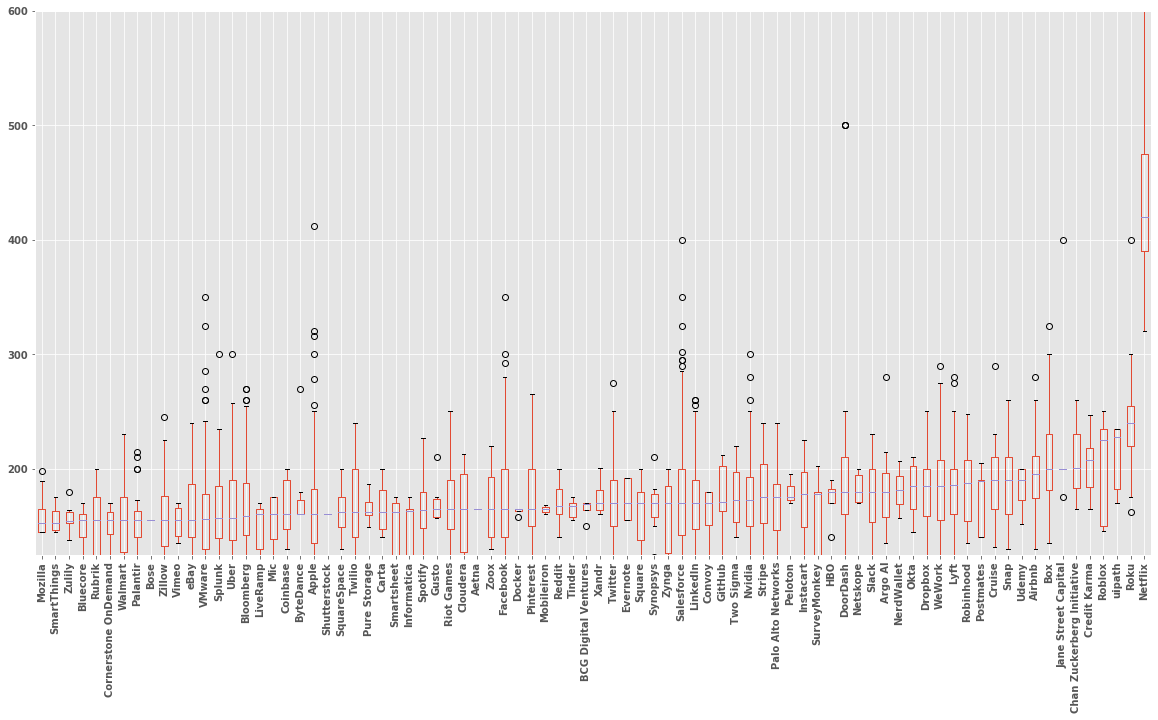

In [26]:
salary_plot = boxplot_sorted(comp, ['company'], 'salary', 150)
salary_plot = salary_plot.set_ylim([125, 600])

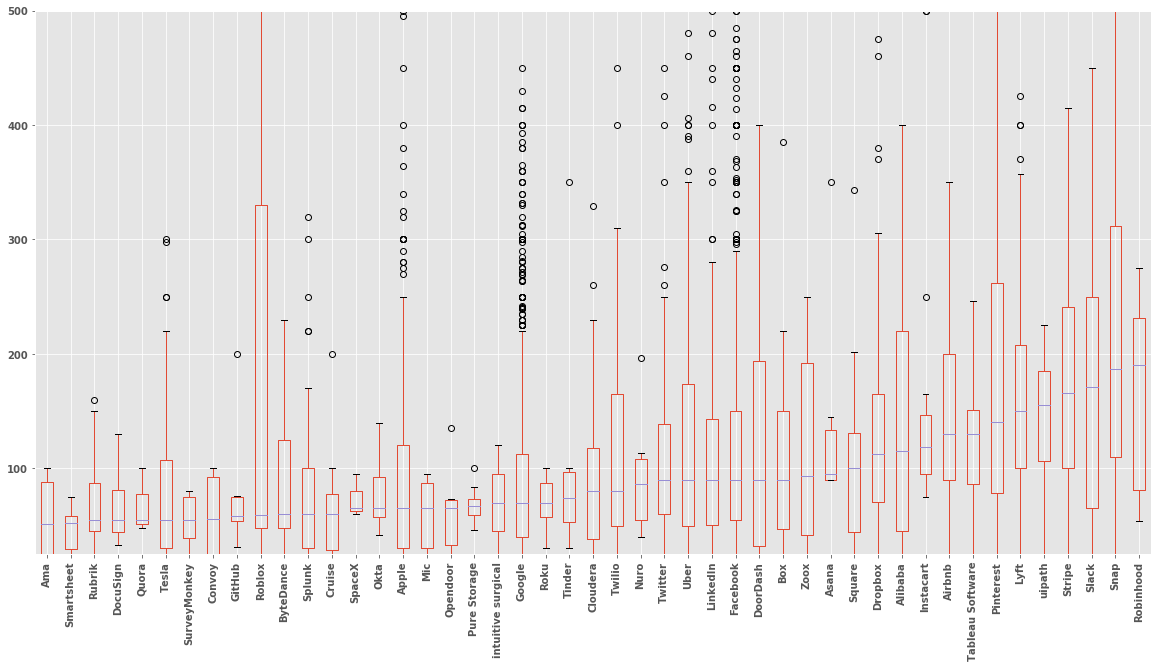

In [27]:
stock_plot = boxplot_sorted(comp, ['company'], 'stock', 50)
stock_plot = stock_plot.set_ylim([25, 500])

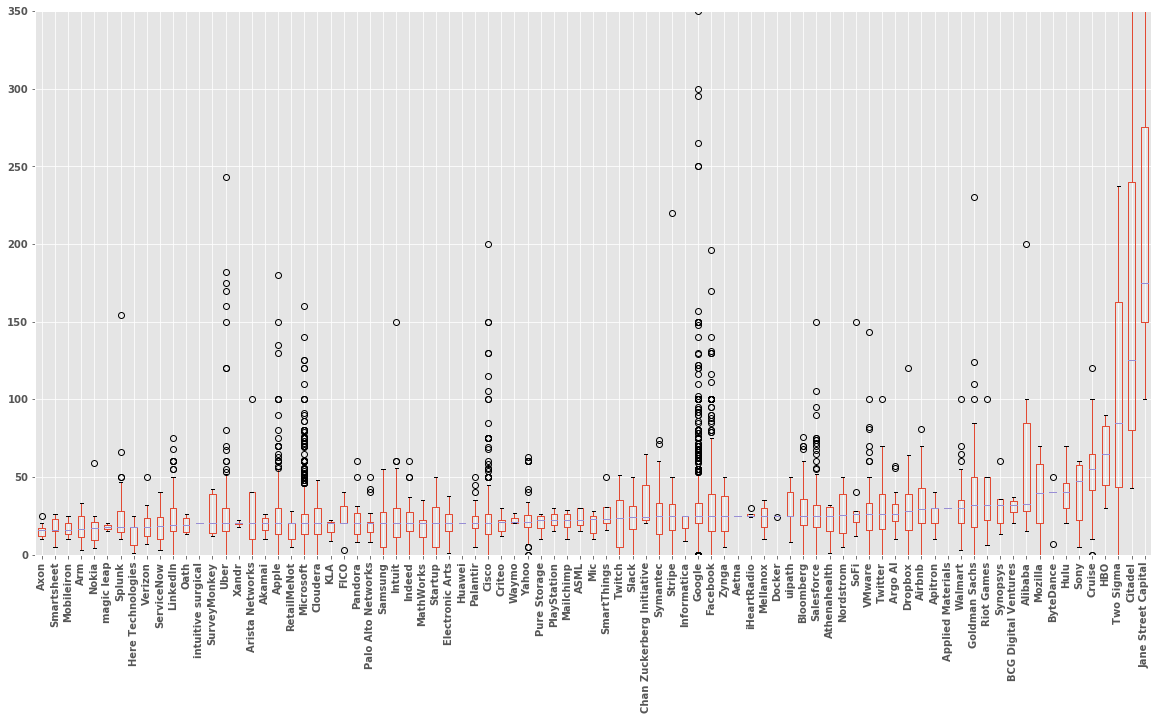

In [28]:
bonus_plot = boxplot_sorted(comp, ['company'], 'bonus', 15)
bonus_plot = bonus_plot.set_ylim([0, 350])

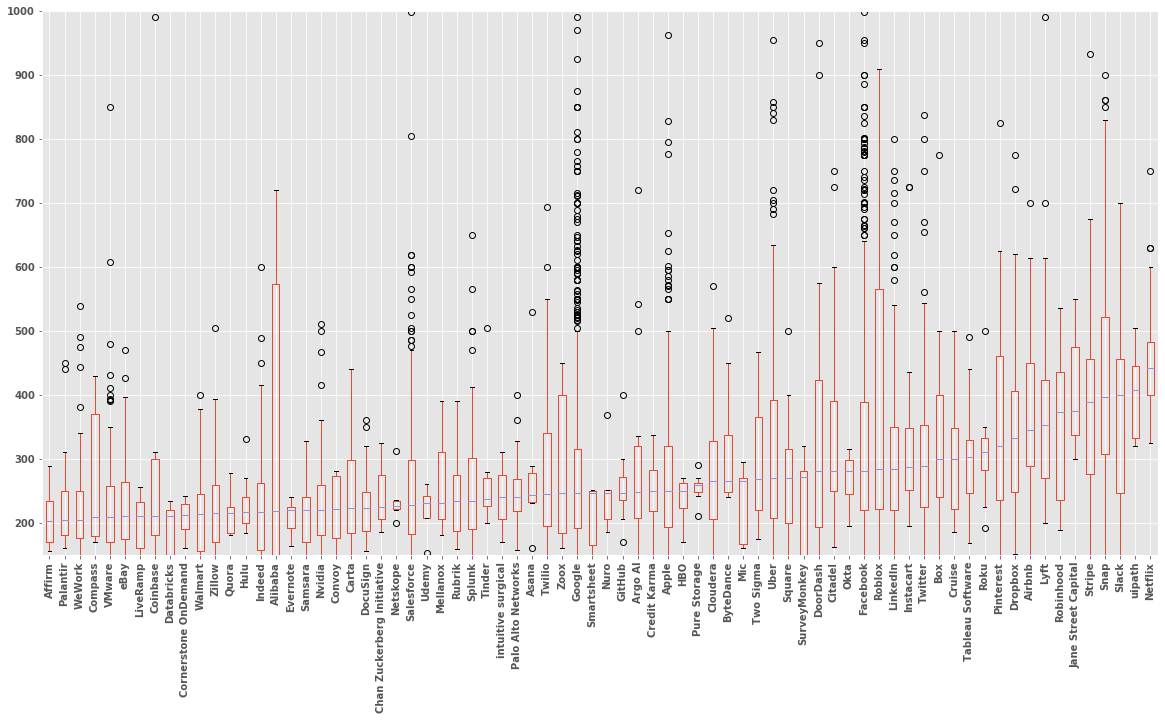

In [29]:
total_comp_plot = boxplot_sorted(comp, ['company'], 'total_comp', 200)
total_comp_plot = total_comp_plot.set_ylim([150, 1000])